In [595]:
import pandas as pd
import numpy as np
import quandl
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
from math import sqrt
import time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
from keras.models import load_model
import keras
import h5py
import requests
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#quandl.ApiConfig.api_key = "zFtyXTJz6DTqqdvEy2gi"

In [ ]:
#Stock Data (DBA and WEAT not available from here)
#data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, ticker = ['DBA'], date = { 'gte': '2012-01-01', 'lte': '2018-04-13' })

### Futures: Continuous contracts (W# - contract # ahead)

In [2]:
#continuous futures W1 is front month
#W1 may18 prices start 3/15/18..futures trade until biz day before 15th of settle month
#data = quandl.get('CHRIS/CME_W7')

In [3]:
#data.to_csv('CME_W7.csv')

In [629]:
#data.head()

### Futures: Individual contracts (all data)

In [ ]:
#individual contract (July 2018)
#data = quandl.get('CME/WN2018')
#data = quandl.get('CME/WK2018')  #may2018'
#data = quandl.get('CME/WH2018')  #mar2018


In [ ]:
#data.iloc[635:,[3]]

### Combining the Financial data sets by Date

In [65]:
# dat = pd.read_csv("Data/CME_W4.csv")
# dat = dat.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpIntPvD'})
# print(dat.head())
# print(len(dat))
# dat.dtypes

# i = 1
# cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']
# dat = dat[cols]
# cols2 = ['W'+str(i) + "_" + x for x in cols[1:]]
# cols2.insert(0,'Date')
# dat.columns = cols2
# dat.head()

# Import, Merge, Clean Data

### Combine all the Futures Contract Data (5 futures files (W1-W5) and 4 stocks )

In [641]:
def fixDate(inDate):
    lst = inDate.split('/')
    if lst[2] < '20':
        lst[2] = '20'+lst[2]
    else:
        lst[2] = '19'+lst[2]
    return '/'.join(lst)
    
import glob

cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']

#get futures data files, sort by 13th char (digit)
filenamesFUT = glob.glob('./Data/CME_W*.csv')
filenamesFUT = sorted(filenamesFUT, key=lambda x: x[12])

#for each file, subset/clean columns, join to W1 by date
for file in filenamesFUT:
    lst = file.split('W')
    cNum = int(lst[1][:1])
    df = pd.read_csv(file)
    
    #W1-3 have date without century, add full year
    if cNum <= 3:
        df['Date'] = df['Date'].apply(fixDate)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpInt'})
    df = df[cols]
    colsTxt = ['W'+str(cNum) + "_" + x for x in cols[1:]]
    colsTxt.insert(0, 'Date')
    df.columns = colsTxt

    if cNum == 1:
        dat = df
    else:
        dat = dat.merge(df, how='left', on='Date')

In [642]:
dat.columns

Index(['Date', 'W1_Open', 'W1_High', 'W1_Low', 'W1_Last', 'W1_Vol', 'W1_OpInt',
       'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt'],
      dtype='object')

### Add Equity data

In [643]:
filenames = glob.glob('./Data/*.csv')
filenamesEQ = [x for x in filenames if x not in filenamesFUT]

colsEQ = ['Date','Close']

for file in filenamesEQ:
    if 'financialALL' not in file and 'imputed' not in file:
        df = pd.read_csv(file, parse_dates=[0])
        df = df[colsEQ]
    
        #extract ticker
        ticker = file.split('/')[2].split('.')[0]

        df.columns = ['Date', ticker]
        
        #merge with futures data
        dat = dat.merge(df, how='left', on='Date')

In [644]:
#keep only the W3 futures contract (3 months ahead rolling contract)
dat = dat[['Date', 'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']]

#change col names
dat.columns = ['Date', 'FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close', 'FUT_Vol', 'FUT_OpInt', 'ADM',
     'BG', 'WEAT', 'DBA']

dat.head()

,Date,FUT_Open,FUT_High,FUT_Low,FUT_Close,FUT_Vol,FUT_OpInt,ADM,BG,WEAT,DBA
0,1959-07-01,197.3,198.1,197.2,197.4,640,2060,NaN,NaN,NaN,NaN
1,1959-07-02,197.7,198.0,197.4,197.5,339,2169,NaN,NaN,NaN,NaN
2,1959-07-06,198.2,198.5,198.0,198.1,1073,2649,NaN,NaN,NaN,NaN
3,1959-07-07,198.4,198.4,197.2,197.2,996,3213,NaN,NaN,NaN,NaN
4,1959-07-08,197.6,197.6,195.4,195.4,1006,3803,NaN,NaN,NaN,NaN


In [645]:
# make Date the index
dat = dat.set_index('Date')

#save to csv
dat.to_csv("./Data/financialALL.csv")

### Split data into 3 datasets (futures, stocks, weather)

In [646]:
futures = dat[['FUT_Open','FUT_High','FUT_Low','FUT_Close','FUT_Vol','FUT_OpInt']]
stocks = dat[['ADM','BG','WEAT','DBA']]
stocks.dropna(inplace=True)

In [647]:
weather = pd.read_csv("./Data/final_weather_imputed.csv", header=0)
weather['Date'] = pd.to_datetime(weather['day'])
weather.drop(columns=['day'], inplace=True)
weather.set_index('Date', inplace=True)
weather.head()

,1F0_avg_rh,1F0_avg_wind_drct,1F0_avg_wind_speed_kts,1F0_climo_high_f,1F0_climo_low_f,1F0_climo_precip_in,1F0_max_dewpoint_f,1F0_max_rh,1F0_max_temp_f,1F0_min_dewpoint_f,...,WWR_max_dewpoint_f,WWR_max_rh,WWR_max_temp_f,WWR_min_dewpoint_f,WWR_min_rh,WWR_min_temp_f,WWR_precip_in,WWR_snow_in,WWR_snowd_in,WWR_X1
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,88.6985,4.95102,3.557650,54.7,32.5,0.06,37.0,100.0,43.0,37.0,...,34.0,100.0000,37.0,30.0,86.6944,30.0,0.08,-99.0,-99.0,0.0
2005-02-01,85.1454,30.55420,5.152340,54.9,32.6,0.07,39.0,100.0,43.0,37.0,...,34.0,100.0000,36.0,34.0,80.5077,34.0,0.00,-99.0,-99.0,1.0
2005-02-02,86.7985,355.15000,3.563940,55.0,32.8,0.08,37.0,100.0,43.0,34.0,...,34.0,100.0000,46.0,30.0,60.7869,30.0,0.00,-99.0,-99.0,2.0
2005-02-03,73.9092,351.57600,1.132680,55.2,33.0,0.06,36.0,100.0,55.0,28.0,...,37.0,92.9165,61.0,30.0,28.7724,30.0,0.00,-99.0,-99.0,3.0
2005-02-04,69.7364,211.26100,0.581704,55.4,33.2,0.07,37.0,100.0,59.0,28.0,...,34.0,93.0280,63.0,34.0,25.3208,34.0,0.00,-99.0,-99.0,4.0


# Feature Engineering

### OHLC Average

Many traders believe in technical analysis, forecasting prices by analyzing statistics based on trading activity. One particular metric watched is the OHLC average which is the average of the Open, High, Low, and Closing prices of a security. 

In [648]:
#add OHLC for each of the futures contracts
futures['FUT_OHLC'] = np.sum(futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Close']],axis=1) / 4

### Moving Averages

In [649]:
MoveAvg = [50,100,200]
for ma in MoveAvg:
    futures['FUT_{}MA'.format(ma)] = futures['FUT_Close'].rolling(window=ma).mean()

### Percent Change

In [650]:
futures['FUT_%Chg'] = futures['FUT_Close'].pct_change()

### Closing price one month ahead (will be the label)

In [656]:
timeShift = 22  #number of days in a month to window data
# futures['FUT_CloseAhead'] = futures['FUT_Close'].shift(-timeShift)
futures.dropna(inplace=True)

### Normalize the data  (call function for whichever cols we want to normalize)

In [657]:
def normalizeData(data):
    minMax = MinMaxScaler()
    normData = minMax.fit_transform(data.values.reshape(-1,1)).ravel()
    return normData

In [658]:
#moving FUT_Cose to 2nd to last col
futures = futures[['FUT_Open', 'FUT_High', 'FUT_Low', 'FUT_Vol', 'FUT_OpInt',
       'FUT_OHLC', 'FUT_50MA', 'FUT_100MA', 'FUT_200MA', 'FUT_%Chg', 'FUT_Close']]

In [661]:
futures.iloc[:,-1].values

array([ 186.  ,  186.  ,  186.3 , ...,  519.75,  516.75,  508.75])

In [665]:
#normalize futures data
fut_norm = futures.iloc[:,:-1].apply(normalizeData, axis=0)

#do close separately so can use model later to denorm
close_normalizer = MinMaxScaler()
fut_norm['FUT_Close'] = close_normalizer.fit_transform(futures.iloc[:,-1].values.reshape(-1,1)).ravel()

In [666]:
#normalize stock and weather data
stk_norm = stocks.iloc[:,:].apply(normalizeData, axis=0)
weather_norm = weather.iloc[:,:].apply(normalizeData, axis=0)

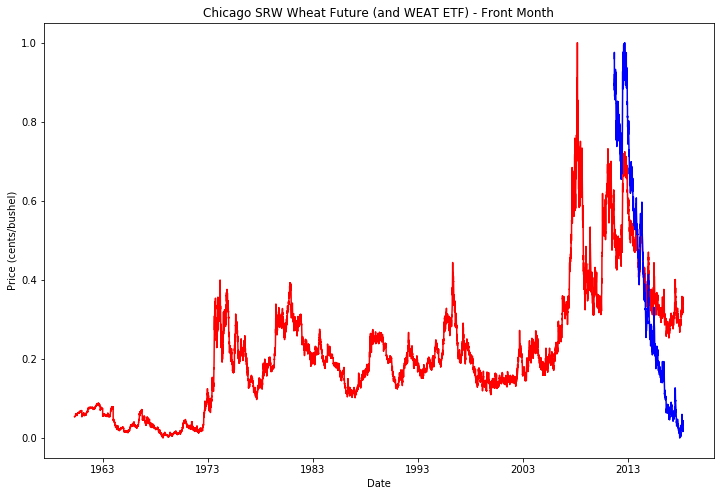

In [667]:
plt.figure(figsize=(12,8))
plt.plot(fut_norm['FUT_Close'], color='r', label='W1')
plt.plot(stk_norm['WEAT'], color='b')
plt.xlabel('Date')
plt.ylabel('Price (cents/bushel)')
plt.title('Chicago SRW Wheat Future (and WEAT ETF) - Front Month');

### Prep Data for NN

3 datasets (pre-windowing)
<ul>
<li>fut_norm
<li>fut_weather_norm
<li>fut_stk_weather_norm
</ul>

In [668]:
fut_weather_norm = weather_norm.merge(fut_norm, left_index=True, right_index=True)

In [669]:
fut_stk_weather_norm = stk_norm.merge(fut_weather_norm, left_index=True, right_index=True)

In [670]:
def prepData(df, window=30):
    
    newData = []

    data = df.as_matrix()
    
    for i in range(len(data) - window): 
        newData.append(data[i: i + (window+1)]) # moving window of data, add one as index starts at 0
    
    #result = np.empty(len(newData), dtype=object)
    #result[:]= [d1, d2]
    #result[:] = newData
    
    newData = np.array(newData)
    split = int(round(len(newData)/3))

    XTrain = newData[:split, :-1]    # data for days d in a month
    yTrain = newData[:split,-1][:,-1] # data for day  d+1 only last col (FUT_CloseAhead)
    
    XValid = newData[split:(2*split),:-1]
    yValid = newData[split:(2*split),-1][:,-1]
    
    XTest = newData[(2*split):,:-1]
    yTest = newData[(2*split):,-1][:,-1]
    

    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [XTrain, yTrain, XValid, yValid, XTest, yTest]

In [671]:
#sets up non-windowing data base NN (assumes last col is target)
def prepDataBase(df):
    split = int(round(len(df)/3))
    df = np.array(df)
    XTrain = df[:split, :-1]    # first split of rows, all but last col
    yTrain = df[:split,-1]      # only last col
    
    XValid = df[split:(2*split),:-1]
    yValid = df[split:(2*split),-1]
    
    XTest = df[(2*split):,:-1]
    yTest = df[(2*split):,-1]
    
    return [XTrain, yTrain, XValid, yValid, XTest, yTest]

# Windowing of Data 

predData() returns RNN ready data: 
<ul>
<li>XTrain
<li>yTrain
<li>XValid
<li>yValid
<li>XTest
<li>yTest
</ul>

In [675]:
# get the non-windowed data for baseline NN
XTrainF_Base, yTrainF_Base, XValidF_Base, yValidF_Base, XTestF_Base, yTestF_Base = prepDataBase(fut_norm)
XTrainFW_Base, yTrainFW_Base, XValidFW_Base, yValidFW_Base, XTestFW_Base, yTestFW_Base = prepDataBase(fut_weather_norm)
XTrainFSW_Base, yTrainFSW_Base, XValidFSW_Base, yValidFSW_Base, XTestFSW_Base, yTestFSW_Base = prepDataBase(fut_stk_weather_norm)


In [676]:
## >>>>> label is FUT_CloseAhead (close price 22 days forward)  ... should we just use FUT_Close?

#just futures data (back to 1960)
XTrainF, yTrainF, XValidF, yValidF, XTestF, yTestF = prepData(fut_norm, timeShift)

#futures and weather (back to 2005)
XTrainFW, yTrainFW, XValidFW, yValidFW, XTestFW, yTestFW = prepData(fut_weather_norm, timeShift)

#futures, weather, and stocks (back to 2011)
XTrainFSW, yTrainFSW, XValidFSW, yValidFSW, XTestFSW, yTestFSW = prepData(fut_stk_weather_norm, timeShift)

### Check if shapes look ok

In [682]:
print(XTrain.shape, yTrain.shape, XValid.shape, yValid.shape, XTest.shape, yTest.shape)

(4855, 22, 12) (4855,) (4855, 22, 12) (4855,) (4855, 22, 12) (4855,)


In [683]:
print(XTrainFW.shape, yTrainFW.shape, XValidFW.shape, yValidFW.shape, XTestFW.shape, yTestFW.shape)

(1084, 22, 1499) (1084,) (1084, 22, 1499) (1084,) (1084, 22, 1499) (1084,)


In [684]:
print(XTrainFSW.shape, yTrainFSW.shape, XValidFSW.shape, yValidFSW.shape, XTestFSW.shape, yTestFSW.shape)

(528, 22, 1503) (528,) (528, 22, 1503) (528,) (527, 22, 1503) (527,)


# Neural Network (RNN, GRU, LSTM)

In [685]:
def build_NN(inShape, neuronList, nnType='RNN'):
    
    model = Sequential()
    model.add(Dense(neuronList[0], input_shape=(inShape[0], inShape[1])))  #input layer
    
    if nnType == 'RNN':    
        model.add(SimpleRNN(neuronList[1], return_sequences=True))
        model.add(SimpleRNN(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'GRU':
        model.add(GRU(neuronList[1], return_sequences=True))
        model.add(GRU(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'LSTM':
        model.add(LSTM(neuronList[1], return_sequences=True)) #stacking LSTM's need return_seq to get 3D output
        model.add(LSTM(neuronList[2]))
        model.add(Dense(neuronList[3], activation='relu'))      
        model.add(Dense(neuronList[4], activation='relu'))
    elif nnType == 'BASE':
        model.add(Dense(neuronList[1], activation='relu'))
        model.add(Dense(neuronList[2], activation='relu'))
        model.add(Dense(neuronList[3], activation='relu'))
        model.add(Dense(neuronList[4], activation='relu'))
    else:
        print('should not be here')
    
    model.add(Dense(neuronList[5], activation='linear', kernel_initializer="uniform")) #output layer
      
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #model.summary() 

    return model

In [699]:
#get the input shapes for each dataset to use input layer of NN model
inShapeF = [timeShift, len(fut_norm.columns)]
inShapeFW = [timeShift, len(fut_weather_norm.columns)]
inShapeFSW = [timeShift, len(fut_stk_weather_norm.columns)]

#neurons list
neurons = [512, 256, 256, 64, 32, 1]
epochs = 50
batchSize = 1000

### Build Models for futures only data

In [622]:
# #models in an array
# modelsNN = []
# #modelsNN.append(build_NN(inShapeF, neurons, nnType='BASE'))
# modelsNN.append(build_NN(inShapeF, neurons, nnType='RNN'))
# modelsNN.append(build_NN(inShapeF, neurons, nnType='GRU'))
# modelsNN.append(build_NN(inShapeF, neurons, nnType='LSTM'))

In [620]:
#modelBASE_F.fit(XTrainF_Base, yTrainF_Base, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

In [692]:
#modelBASE_F = build_NN(inShapeF, neurons, nnType='BASE')
modelRNN_F = build_NN(inShapeF, neurons, nnType='RNN')
modelGRU_F = build_NN(inShapeF, neurons, nnType='GRU')
modelLSTM_F = build_NN(inShapeF, neurons, nnType='LSTM')

modelRNN_FW = build_NN(inShapeFW, neurons, nnType='RNN')
modelGRU_FW = build_NN(inShapeFW, neurons, nnType='GRU')
modelLSTM_FW = build_NN(inShapeFW, neurons, nnType='LSTM')

modelRNN_FSW = build_NN(inShapeFSW, neurons, nnType='RNN')
modelGRU_FSW = build_NN(inShapeFSW, neurons, nnType='GRU')
modelLSTM_FSW = build_NN(inShapeFSW, neurons, nnType='LSTM')

print(modelRNN_F.summary(),'\n')
print(modelGRU_F.summary(),'\n')
print(modelLSTM_F.summary(),'\n')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_318 (Dense)            (None, 22, 512)           6144      
_________________________________________________________________
simple_rnn_39 (SimpleRNN)    (None, 22, 256)           196864    
_________________________________________________________________
simple_rnn_40 (SimpleRNN)    (None, 256)               131328    
_________________________________________________________________
dense_319 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_320 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 33        
Total params: 352,897
Trainable params: 352,897
Non-trainable params: 0
_________________________________________________________________
None

In [695]:
#get the loss
def model_traintest_loss(mod, XTrain, yTrain, XTest, yTest):
    trainLoss = mod.evaluate(XTrain, yTrain, verbose=0)
    testLoss = mod.evaluate(XTest, yTest, verbose=0)
    print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return trainLoss[0], testLoss[0]

def model_loss(mod, X, y):
    loss = mod.evaluate(X, y, verbose=0)
    #print('Train Score: {:.5f} MSE ({:.2f} RMSE)'.format(trainLoss[0], math.sqrt(trainLoss[0])))
    #print('Test Score: {:.5f} MSE ({:.2f} RMSE)'.format(testLoss[0], math.sqrt(testLoss[0])))
    return loss[0]  #returns MSE

In [ ]:
# for model in modelsNN:
#     fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
#     fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
#     fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

## Fit Models:  Futures

In [696]:
%%time
modelRNN_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_F.fit(XTrainF, yTrainF, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 3889 samples, validate on 973 samples
Epoch 1/50
3889/3889 [==============================] - 6s 2ms/step - loss: 0.0119 - acc: 2.5714e-04 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 2/50
3889/3889 [==============================] - 4s 994us/step - loss: 0.0063 - acc: 2.5714e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 3/50
3889/3889 [==============================] - 4s 1ms/step - loss: 0.0022 - acc: 2.5714e-04 - val_loss: 3.5410e-04 - val_acc: 0.0000e+00
Epoch 4/50
3889/3889 [==============================] - 4s 1ms/step - loss: 7.1602e-04 - acc: 2.5714e-04 - val_loss: 5.7556e-04 - val_acc: 0.0000e+00
Epoch 5/50
3889/3889 [==============================] - 4s 1ms/step - loss: 4.2276e-04 - acc: 2.5714e-04 - val_loss: 3.7100e-04 - val_acc: 0.0000e+00
Epoch 6/50
3889/3889 [==============================] - 4s 1ms/step - loss: 3.0539e-04 - acc: 2.5714e-04 - val_loss: 2.3314e-04 - val_acc: 0.0000e+00
Epoch 7/50
3889/3889 [==============================] - 4s 989us/step -

3889/3889 [==============================] - 9s 2ms/step - loss: 2.1958e-04 - acc: 2.5714e-04 - val_loss: 3.3984e-04 - val_acc: 0.0000e+00
Epoch 5/50
3889/3889 [==============================] - 9s 2ms/step - loss: 1.3984e-04 - acc: 2.5714e-04 - val_loss: 2.1853e-04 - val_acc: 0.0000e+00
Epoch 6/50
3889/3889 [==============================] - 9s 2ms/step - loss: 9.2266e-05 - acc: 2.5714e-04 - val_loss: 2.2703e-04 - val_acc: 0.0000e+00
Epoch 7/50
3889/3889 [==============================] - 9s 2ms/step - loss: 7.5449e-05 - acc: 2.5714e-04 - val_loss: 9.8924e-05 - val_acc: 0.0000e+00
Epoch 8/50
3889/3889 [==============================] - 9s 2ms/step - loss: 4.8869e-05 - acc: 2.5714e-04 - val_loss: 5.9053e-05 - val_acc: 0.0000e+00
Epoch 9/50
3889/3889 [==============================] - 9s 2ms/step - loss: 3.7604e-05 - acc: 2.5714e-04 - val_loss: 4.5367e-05 - val_acc: 0.0000e+00
Epoch 10/50
3889/3889 [==============================] - 9s 2ms/step - loss: 3.3294e-05 - acc: 2.5714e-04 - val

3889/3889 [==============================] - 10s 3ms/step - loss: 1.4536e-04 - acc: 2.5714e-04 - val_loss: 2.3490e-04 - val_acc: 0.0000e+00
Epoch 9/50
3889/3889 [==============================] - 10s 3ms/step - loss: 1.1827e-04 - acc: 2.5714e-04 - val_loss: 1.1847e-04 - val_acc: 0.0000e+00
Epoch 10/50
3889/3889 [==============================] - 10s 3ms/step - loss: 9.2411e-05 - acc: 2.5714e-04 - val_loss: 9.9549e-05 - val_acc: 0.0000e+00
Epoch 11/50
3889/3889 [==============================] - 10s 3ms/step - loss: 7.7487e-05 - acc: 2.5714e-04 - val_loss: 9.3241e-05 - val_acc: 0.0000e+00
Epoch 12/50
3889/3889 [==============================] - 10s 3ms/step - loss: 6.8528e-05 - acc: 2.5714e-04 - val_loss: 7.6116e-05 - val_acc: 0.0000e+00
Epoch 13/50
3889/3889 [==============================] - 10s 3ms/step - loss: 6.5426e-05 - acc: 2.5714e-04 - val_loss: 9.9883e-05 - val_acc: 0.0000e+00
Epoch 14/50
3889/3889 [==============================] - 10s 3ms/step - loss: 6.1647e-05 - acc: 2.571

## Fit Models:  Futures only data (truncated to # rows of weather data)

In [ ]:
# add in subsetting rows to match weather data

## Fit Models:  Futures + Weather data

In [744]:
%%time
modelRNN_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FW.fit(XTrainFW, yTrainFW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 867 samples, validate on 217 samples
Epoch 1/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0460 - acc: 0.0000e+00 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 2/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0391 - acc: 0.0000e+00 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 3/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0371 - acc: 0.0000e+00 - val_loss: 0.0145 - val_acc: 0.0000e+00
Epoch 4/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0171 - val_acc: 0.0000e+00
Epoch 5/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0391 - acc: 0.0000e+00 - val_loss: 0.0156 - val_acc: 0.0000e+00
Epoch 6/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0383 - acc: 0.0000e+00 - val_loss: 0.0113 - val_acc: 0.0000e+00
Epoch 7/50
867/867 [==============================] - 2s 2ms/step - loss: 0.0367 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 9/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0221 - acc: 0.0000e+00 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 10/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0466 - acc: 0.0000e+00 - val_loss: 0.0072 - val_acc: 0.0000e+00
Epoch 11/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 12/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0355 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 13/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0293 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 14/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0258 - acc: 0.0000e+00 - val_loss: 0.0093 - val_acc: 0.0000e+00
Epoch 15/50
867/867 [==============================] - 3s 3ms/step - loss: 0.0269 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 16/50
86

Epoch 18/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 19/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 20/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0102 - val_acc: 0.0000e+00
Epoch 21/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 22/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0381 - acc: 0.0000e+00 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 23/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 24/50
867/867 [==============================] - 3s 4ms/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0098 - val_acc: 0.0000e+00
Epoch 25/50
8

## Fit Models: Futures + Weather + Stock data

In [743]:
%%time
modelRNN_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelGRU_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)
modelLSTM_FSW.fit(XTrainFSW, yTrainFSW, batch_size=batchSize, epochs=epochs, validation_split=0.2, verbose=1)

Train on 422 samples, validate on 106 samples
Epoch 1/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0056 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 3/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 4/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 5/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0058 - acc: 0.0000e+00 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 6/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 7/50
422/422 [==============================] - 1s 2ms/step - loss: 0.0060 - acc: 0.0000e+00 - val_loss: 0.0

Epoch 9/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0035 - acc: 0.0000e+00 - val_loss: 0.0247 - val_acc: 0.0000e+00
Epoch 10/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0033 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 11/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0032 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 0.0000e+00
Epoch 12/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0033 - acc: 0.0000e+00 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 13/50
422/422 [==============================] - 1s 4ms/step - loss: 0.0034 - acc: 0.0000e+00 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 14/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0032 - acc: 0.0000e+00 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 15/50
422/422 [==============================] - 1s 3ms/step - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0265 - val_acc: 0.0000e+00
Epoch 16/50
42

Epoch 17/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 18/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 19/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 20/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 21/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 22/50
422/422 [==============================] - 2s 5ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 23/50
422/422 [==============================] - 2s 4ms/step - loss: 0.0072 - acc: 0.0000e+00 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 24/50
4

In [745]:
NNmods = ['RNN','GRU','LSTM']
Datasets = ['FUT','FUT_Weather','FUT_STK_Weather']

loss_train = []
loss_test = []

temp = []
temp.append(model_loss(modelRNN_F, XTrainF, yTrainF))
temp.append(model_loss(modelRNN_FW, XTrainFW, yTrainFW))
temp.append(model_loss(modelRNN_FSW, XTrainFSW, yTrainFSW))

loss_train.append(temp)
temp = []

temp.append(model_loss(modelGRU_F, XTrainF, yTrainF))
temp.append(model_loss(modelGRU_FW, XTrainFW, yTrainFW))
temp.append(model_loss(modelGRU_FSW, XTrainFSW, yTrainFSW))

loss_train.append(temp)
temp = []

temp.append(model_loss(modelLSTM_F, XTrainF, yTrainF))
temp.append(model_loss(modelLSTM_FW, XTrainFW, yTrainFW))
temp.append(model_loss(modelLSTM_FSW, XTrainFSW, yTrainFSW))

loss_train.append(temp)
temp = []

temp.append(model_loss(modelRNN_F, XTestF, yTestF))
temp.append(model_loss(modelRNN_FW, XTestFW, yTestFW))
temp.append(model_loss(modelRNN_FSW, XTestFSW, yTestFSW))

loss_test.append(temp)
temp = []

temp.append(model_loss(modelGRU_F, XTestF, yTestF))
temp.append(model_loss(modelGRU_FW, XTestFW, yTestFW))
temp.append(model_loss(modelGRU_FSW, XTestFSW, yTestFSW))

loss_test.append(temp)
temp = []

temp.append(model_loss(modelLSTM_F, XTestF, yTestF))
temp.append(model_loss(modelLSTM_FW, XTestFW, yTestFW))
temp.append(model_loss(modelLSTM_FSW, XTestFSW, yTestFSW))

loss_test.append(temp)
temp = []

train_table = pd.DataFrame(loss_train, index=NNmods, columns=Datasets)
test_table = pd.DataFrame(loss_test, index=NNmods, columns=Datasets)

In [746]:
train_table

,FUT,FUT_Weather,FUT_STK_Weather
RNN,0.000038,0.010219,0.005976
GRU,0.000025,0.022012,0.006434
LSTM,0.000023,0.032223,0.006517


In [747]:
test_table

,FUT,FUT_Weather,FUT_STK_Weather
RNN,0.008607,0.063907,0.077143
GRU,0.000836,0.310370,0.078347
LSTM,0.000976,0.005702,0.064051


In [756]:
def denormalize(norm_close):       
    #normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    denorm_close = close_normalizer.inverse_transform(norm_close)
      
    return denorm_close

### Predictions: LSTM for FUT only

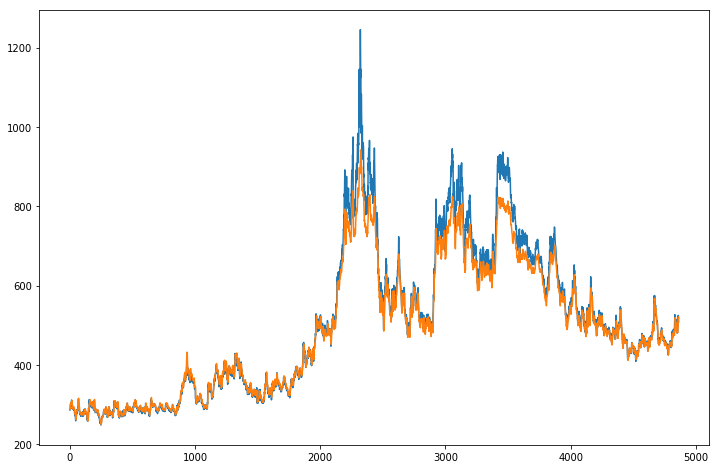

In [754]:
yPred_norm = modelLSTM_F.predict(XTestF)
yPred_denorm = denormalize(yPred_denorm)
yTestF_denorm = denormalize(yTestF.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestF))), yTestF_denorm)
plt.plot(list(range(len(yTestF))), yPred_denorm);

### Predictions: LSTM for FUT+Weather

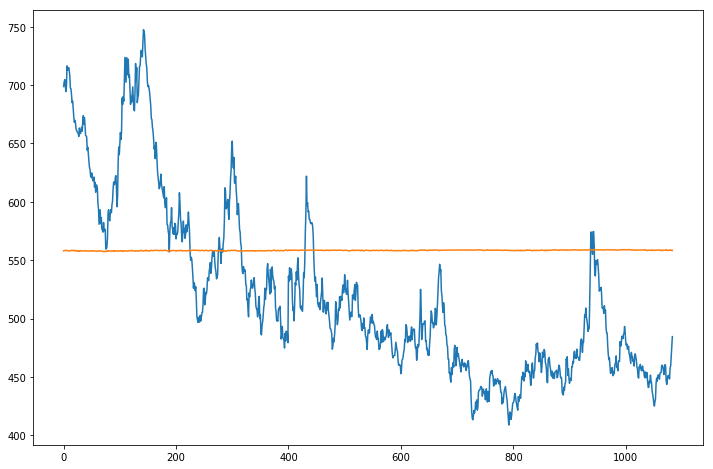

In [755]:
yPredFW_norm = modelLSTM_FW.predict(XTestFW)
yPredFW_denorm = denormalize(yPredFW_denorm)
yTestFW_denorm = denormalize(yTestFW.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.plot(list(range(len(yTestFW))), yTestFW_denorm)
plt.plot(list(range(len(yTestFW))), yPredFW_denorm);

In [752]:
yPredFW_norm

array([[ 558.01147461],
       [ 558.17163086],
       [ 558.21929932],
       ..., 
       [ 558.26690674],
       [ 558.69512939],
       [ 558.44006348]], dtype=float32)

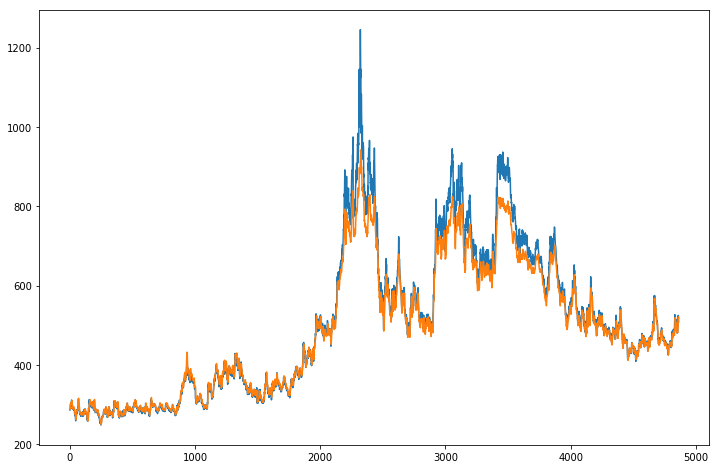